In [127]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog
import pickle
from tqdm import tqdm

In [128]:
labels = pd.read_csv('./train_label.csv')

In [129]:
labels.head()

,name,height,left,top,width,label
0,1.png,219,246,77,81,1
1,1.png,219,323,81,96,9
2,2.png,32,77,29,23,2
3,2.png,32,98,25,26,3
4,3.png,15,17,5,8,2


In [130]:
train_path = '../data/train/' #### TO BE CHANGEDDDDD
train_images = os.listdir(train_path)

In [131]:
def get_cropped(labels, i, option =0):
    image = cv2.imread(os.path.join(train_path, labels['name'][i]))
    x1 = labels['top'][i]
    if (x1 < 0): 
        return None
    x2 = x1 + labels['height'][i]
    y1 = labels['left'][i]
    if (y1 < 0): 
        return None
    y2 = y1 + labels['width'][i]
    cropimg = image[x1:x2,y1:y2,:]
    if (option == 0): #16x32
        if (((x2-x1) < 32 ) or ((y2-y1)<16)):
            #print('return NONE')
            return None
    elif(option == 1): #16x32
        if (((x2-x1) < 16 ) or ((y2-y1)<8)):
            #print('return NONE')
            return None
    return cropimg

In [132]:
def resize_img(img, option = 0):
    #option 0: 16x32
    #option 1: 8x16
    if option == 0:
        dim = (16,32)
    elif option == 1:
        dim = (8,16)
    #print(img.shape)
    img_resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return img_resized

In [133]:
filename = 'HOG_16x32'
count = 0
num_desc = 72
tosave = np.zeros((len(labels), num_desc))
for i in tqdm(range(len(labels))):
    I = get_cropped(labels, i)
    if (I is None):
        count = count+1
        continue
    I = resize_img(I, option =0)
    desc= hog(I, pixels_per_cell = (8,8), cells_per_block = (4,2))
    #print(tosave[i,:].shape)
    
    #print('i is', i)
    tosave[i,:] = desc 


100%|██████████| 73257/73257 [01:54<00:00, 641.42it/s]


In [134]:
print(tosave.shape)
print(count)

(73257, 72)
47303


In [135]:
#print(tosave.shape)
tosavenew = np.array([])
for i in tqdm(range(len(labels))):
    if np.all(tosave[i,:] == np.zeros(num_desc)):
        continue
    tosavenew = np.append(tosavenew, tosave[i,:])
print(tosavenew.shape)
tosavenew = tosavenew.reshape(-1,num_desc)

100%|██████████| 73257/73257 [01:30<00:00, 806.73it/s](1868688,)



In [136]:
tosavenew.shape

(25954, 72)

In [137]:
np.all?

Signature: np.all(a, axis=None, out=None, keepdims=<no value>)
Docstring:
Test whether all array elements along a given axis evaluate to True.

Parameters
----------
a : array_like
    Input array or object that can be converted to an array.
axis : None or int or tuple of ints, optional
    Axis or axes along which a logical AND reduction is performed.
    The default (``axis=None``) is to perform a logical AND over all
    the dimensions of the input array. `axis` may be negative, in
    which case it counts from the last to the first axis.

    .. versionadded:: 1.7.0

    If this is a tuple of ints, a reduction is performed on multiple
    axes, instead of a single axis or all the axes as before.
out : ndarray, optional
    Alternate output array in which to place the result.
    It must have the same shape as the expected output and its
    type is preserved (e.g., if ``dtype(out)`` is float, the result
    will consist of 0.0's and 1.0's). See `ufuncs-output-type` for more
    det

In [138]:
print(tosave[25,:])

[0.0164859  0.00990257 0.         0.04093162 0.26161829 0.26161829
 0.         0.         0.         0.15322425 0.00330402 0.
 0.02251627 0.11838201 0.1746249  0.05095346 0.06800285 0.03857242
 0.07752021 0.0699371  0.22817682 0.11119084 0.07572529 0.06692876
 0.00800017 0.05052976 0.08640209 0.26161829 0.26161829 0.02307171
 0.01568133 0.02826122 0.00730382 0.0291453  0.01866014 0.05965252
 0.01056957 0.01335314 0.00958456 0.03929813 0.21108711 0.14296301
 0.0537934  0.07720818 0.02066918 0.17379447 0.05958376 0.02380291
 0.02103786 0.04561073 0.02600312 0.11713057 0.26161829 0.16382385
 0.01822125 0.00782115 0.02824219 0.15227724 0.26161829 0.1982504
 0.03845719 0.04488042 0.00570665 0.14426601 0.26161829 0.26161829
 0.16632083 0.02951912 0.         0.01229589 0.00312846 0.01340451]


In [139]:
fileObj = open('./' + filename, 'wb')
pickle.dump(tosave, fileObj)

In [140]:
tosave[0:1,:]

array([[0.08865121, 0.03908276, 0.04266275, 0.02193004, 0.0985876 ,
        0.04505753, 0.05149832, 0.04057649, 0.07506553, 0.33133469,
        0.08177384, 0.15747951, 0.06109288, 0.0507671 , 0.05123695,
        0.        , 0.08176088, 0.12664996, 0.13236724, 0.01246605,
        0.01459592, 0.02312303, 0.08635383, 0.04736925, 0.02969023,
        0.03754305, 0.04599578, 0.33133469, 0.12888973, 0.00552679,
        0.01588983, 0.05204059, 0.        , 0.00773644, 0.01496989,
        0.13670478, 0.33133469, 0.07582122, 0.029067  , 0.02593306,
        0.05725895, 0.03265404, 0.02576514, 0.03069959, 0.05157627,
        0.33133469, 0.08518856, 0.00552679, 0.01854749, 0.03793283,
        0.00592334, 0.01505464, 0.03623455, 0.05135525, 0.13449043,
        0.0940315 , 0.10699521, 0.16413676, 0.27435963, 0.15503402,
        0.03335249, 0.07089774, 0.04161869, 0.0852199 , 0.0191071 ,
        0.02455312, 0.14106103, 0.33133469, 0.20747629, 0.0374239 ,
        0.04960112, 0.08226533]])

1.png


name      1.png
height      219
left        246
top          77
width        81
label         1
Name: 0, dtype: object

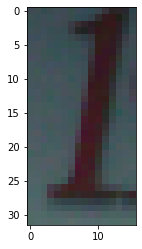

In [141]:
index = 0
#image = cv2.imread(os.path.join(train_path, labels['name'][index]))
todisp = resize_img(get_cropped(labels, index))
plt.imshow(todisp)
print(labels['name'][index])
labels.loc[index]

In [142]:
todisp.shape

(32, 16, 3)

In [143]:
des , hogim = hog(todisp, pixels_per_cell = (8,8), cells_per_block = (4,2), visualize = True)


In [144]:
des.shape

(72,)

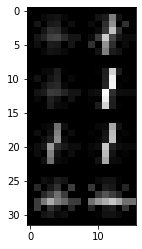

In [145]:
plt.imshow(hogim, cmap = 'gray')